# Using PCA to evaluate instant coffee origin

In this notebook, we will look at a dataset of infrared diffuse reflectance (FTIR-DRIFTS) spectra. These spectra are freeze dried instant coffees that are derived from Arabica or Robusta beans. The original paper performing the analysis is "Near- and Mid-Infrared Spectroscopies in Food Authentication: Coffee Varietal Identification" [10.1021/jf970337t](https://doi.org/10.1021/jf970337t). You can download a copy of the data from the [Quadram Institute](https://csr.quadram.ac.uk/example-datasets-for-download/).

Our goal will be to see if we can use Principal Component Analysis (PCA) to distinguish between the coffee bean used to make that instant coffee sample.

Let's start by importing the packages we will use.

In [11]:
#These imports are for plotting and data handling
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#The following import contains the PCA function we will use
from sklearn.decomposition import PCA

#The following import is for loading spectra and preprocessing
from porchlight import SpectralData


## A preliminary inspection

The first step we need to take is to inspect the data, and understand what we are dealing with.

This means:
1) Loading the spectra
2) Plotting the spectra
3) Make decisions based on what we see.

There's a couple of ways we can proceed with this, but we can use Porchlight's SpectralData backend to do it for us.

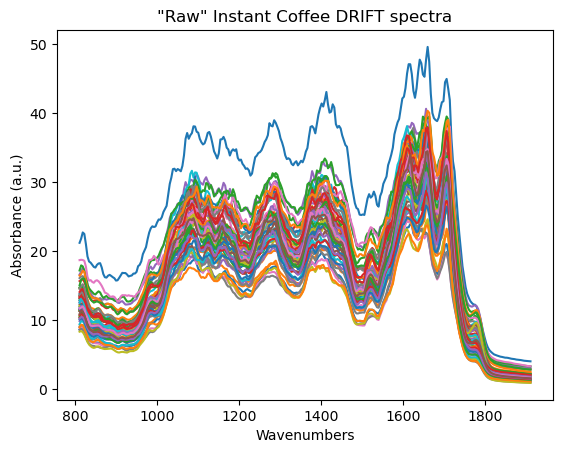

In [10]:
#1) Load the dataset with labels removed
spectra = SpectralData('./Data/InstantCoffee/FTIR_Spectra_instant_coffee_unlabeled.csv')

#2) Since the spectra are stored as a pandas DataFrame, we can call the plotting function directly. Don't forget to transpose the data first!
spectra.spc.transpose().plot(legend=False, ylabel='Absorbance (a.u.)', title='"Raw" Instant Coffee DRIFT spectra')
plt.show()


What do you notice in the spectra? Take a moment to write some things you see.

Write your notes here:

Some possible answers include:
- The spectra have inconsistent intensities
- The top spectra is very different than the rest
- This data was already previously processed as the Absorbance is not within the normal range of FTIR spectra (0-1)

## Let's perform PCA

Although there are defects in the spectra, there is a possibility that they do not interfere with our task: determining if the coffee sample is Robusta or Arabica. Usually a good first step, before attempting to preprocess the data, is to simply perform a PCA analysis and see if any patterns emerge from the data.

Let's do that here using scikit-learn's implementation of PCA. We'll also need to get the labels for the spectra in order to make sense of the spectra.


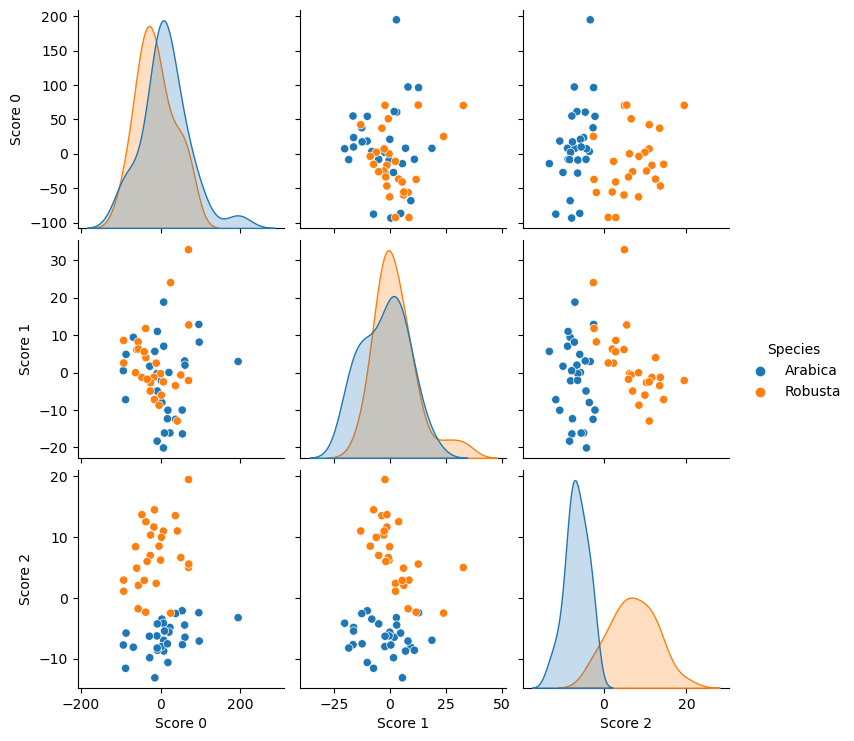

In [48]:
# load the spectral labels. We'll need to provide information that the first row contains a header
labels = pd.read_csv('./Data/InstantCoffee/FTIR_Spectra_instant_coffee_labels.csv', header=0)

# make the PCA object. We'll limit to only the first 3 components
pca = PCA(n_components=3)

# fit and transform the spectra into scores, then pretty it up. We'll also attach the labels to this DataFrame
scores = pca.fit_transform(spectra.spc)
scores = pd.DataFrame(scores, columns=[f"Score {x}" for x in range(scores.shape[1])])
scores['Species'] = labels['Species']


#Plot the scores using seaborn's pairplot, coloring by specie
sns.pairplot(scores, hue='Species')
plt.show()

### How do we interpret a pairplot?

#### The diagonals
With the default settings, the diagonal of the pairplot contains a kernal density estimate (KDE). Essentially, it's trying to make a probability distribution for that category. The most important concept for us is that it tells us how that category is distributed for that score.

If we look at Score 0 (top left) and Score 1 (middle), we see that the KDEs overlap. This suggests that regardless of the coffee species, principal components 0 and 1 do not identify any values that can be used to discriminate them. However, Score 2 (bottom right) shows a difference between the distributions. This tells us the principle component 2 has identified some changes between the spectra which separates the two species!

#### The off-diagonals
The off diagonals show a scatter plot of the scores, with plot flipping on the other side of the diagonal. So the top middle plot shows Score 0 vs Score 1, while the middle left shows Score 1 vs Score 0. We can use these to see if there are interactions between the scores. In this cases, there does not appear to be any major differences when we plot Score 0 or 1 against Score 2.

## Let's try to preprocess the data

We saw some defects in spectra, so let's try preprocesing it. A common technique in diffuse reflectance spectra is to perform standard normal variate (SNV) correction. Let's try that here and plot it.

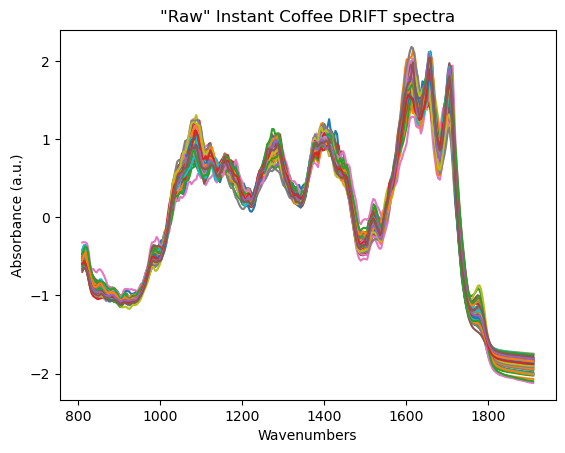

In [52]:
#Use porchlight to perform SNV then plot.
spectra.reset()
spectra.snv()

spectra.spc.transpose().plot(legend=False, ylabel='Absorbance (a.u.)', title='"Raw" Instant Coffee DRIFT spectra')
plt.show()

What changes do you observe between the preprocessed and the raw data? Write your notes here.

The general answer should be that the spectra have been normalized and generally look similar now. Some might note the shoulder at ~1750 cm$^{-1}$ has varying intensities.



Now, it's your turn to do some programming. Fill in the blanks below to perform a PCA analysis on the preprocessed spectra.

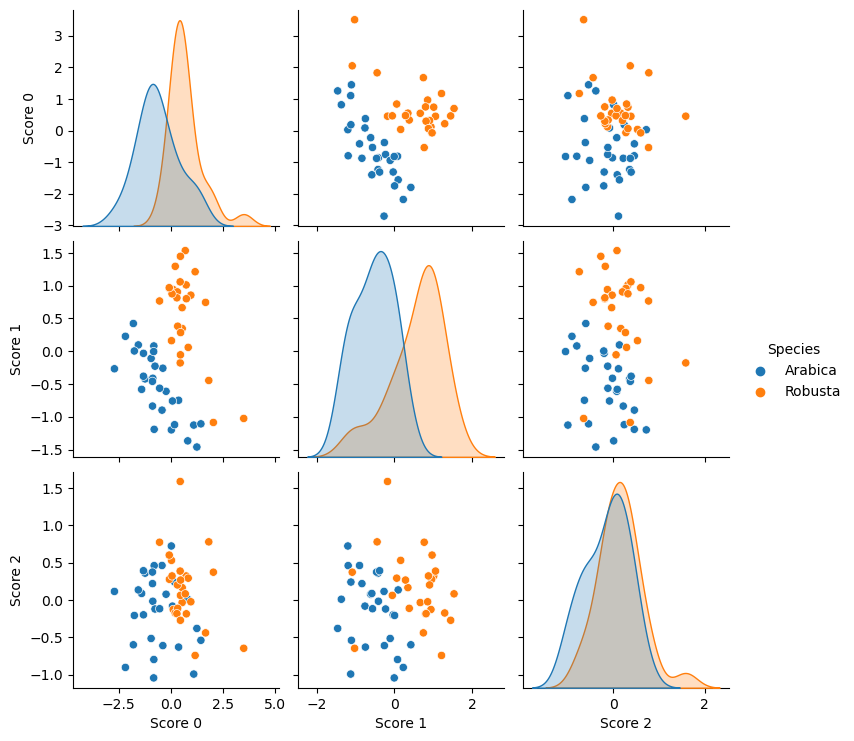

In [51]:
# make the PCA object. We'll limit to only the first 3 components
pca = PCA(n_components=3)

# fit and transform the spectra into scores, then pretty it up. We'll also attach the labels to this DataFrame
scores = pca.fit_transform(spectra.spc)
scores = pd.DataFrame(scores, columns=[f"Score {x}" for x in range(scores.shape[1])])
scores['Species'] = labels['Species']


#Plot the scores using seaborn's pairplot, coloring by specie
sns.pairplot(scores, hue='Species')
plt.show()

**What do you see?**

Scores 0 and 1 are hitting on features that separate Arabica and Robusta. Score 2 does not contain any meaningful information, except for a Robusta spectra that is outside the range of the rest of that group.

**Does this seem to perform better or worse at separating the two?**

The answers might vary. Some might say no, the preprocessed data is not better as previously, score 2 gave a very clear delineation between Arabica and Robusta.

However, this is in fact improved as it is no longer the third component that contains the information necessary to separate the two, but the first and the second. The main variance in the spectra is the fingerprint of Arabica and Robusta. Additionally, in the unprocessed data, some Arabica and Robusta spectra overlapped. Here, there is no more overlap. A line can be drawn in PC space that would correctly classify Arabica or Robusta.

-----------
This notebook was made by Jakub Konkol. All rights reserved.